# Diagnostic MLP – 430 Features

Version 0.2  
Auteur : Yoan  
Date : 2025‑06‑30

Objectif : prédire automatiquement si un patient est malade (1) ou sain (0) à l’aide de 430 caractéristiques numériques extraites de données d’IRM.

Le notebook suit un pipeline complet : ingestion, feature engineering, split, hyperparameter tuning, entraînement final, évaluation et explicabilité.


In [13]:
# --- Configuration générale ---
from pathlib import Path
from robust_evaluation_tools.robust_MLP import PatientMLP, MODEL_DIR, build_mlp_from_config, DEFAULT_MODEL_CONFIG
import torch
DATA_DIR  = Path("DONNES/processed/compilation/classic/mlp")  # Données MLP augmentées
DATA_FILE = DATA_DIR / "compilation.all_metrics.with_camcan.csv.gz"
disease = "ALL"
RUN_NAME  = f"mlp7_{disease}"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
SEED = 41

from robust_evaluation_tools.MLP_train import (
    PatientDataset, make_loaders, train_epoch, eval_epoch, fit
)


## Guide d’utilisation & Configuration unique

- Tous les paramètres du modèle et de l’entraînement sont centralisés ci‑dessous.
- Pour changer le nombre de couches, modifiez `MODEL_CFG["hidden_dims"]` (ex: `[512, 256]`).
- Activez/désactivez Optuna via `USE_OPTUNA`.
- Les artefacts sont enregistrés dans `Pytorch_models/` avec `RUN_NAME`.


In [14]:
# --- Config centralisée (modèle + entraînement) ---
from robust_evaluation_tools.robust_MLP import build_mlp_from_config, DEFAULT_MODEL_CONFIG

USE_OPTUNA = False  # False: utilise MODEL_CFG; True: lance l’Optuna

MODEL_CFG = {
    **DEFAULT_MODEL_CONFIG,
    # Modèle
    "in_features": 430,              # change si le nb de features évolue
    "hidden_dims": [256, 128, 64],   # nb de couches = len(hidden_dims)
    "activation": "relu",           # "relu" | "gelu" | "leaky_relu" | "elu" | "tanh"
    "batch_norm": True,
    "dropout": 0.5,                  # float ou liste par couche, ex: [0.1, 0.2, 0.2]
}

TRAIN_CFG = {
    "batch_size": 64,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "epochs": 100,
    "patience": 10,
    "neg_weight": 10.0,              # pondération de la classe 0 dans la loss
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [15]:
# INSTALLATION (décommente si nécessaire)
# %pip install -q pandas numpy scikit-learn torch optuna shap tensorboard joblib tqdm


In [16]:
import numpy as np
import pandas as pd
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, roc_auc_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,
                             PrecisionRecallDisplay)
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import joblib, random, os, json, optuna
from tqdm.auto import tqdm

from robust_evaluation_tools.synthectic_sites_generations import augment_df, split_train_test, generate_sites_no_file
from robust_evaluation_tools.robust_utils import remove_covariates_effects_metrics

# ----- Helpers -----
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(SEED)

device = "cpu"
print("Device:", device)

def show_class_balance(y):
    vals, counts = np.unique(y, return_counts=True)
    for v, c in zip(vals, counts):
        print(f"Classe {int(v)} : {c}")

def plot_curves(train, val, ylabel="Loss"):
    plt.figure(figsize=(6,4))
    epochs = range(1, len(train)+1)
    plt.plot(epochs, train, label="train")
    plt.plot(epochs, val,   label="val")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(f"Courbe {ylabel}")
    plt.legend(); plt.grid(True); plt.show()


Device: cpu


In [17]:


# Si disease == "ALL", on fusionne toutes les maladies sans doublons de SID
if disease == "ALL":
    # sids_vus = set()
    # df_total = pd.DataFrame()
    # for maladie in ["AD", "ADHD", "BIP", "MCI", "SCHZ", "TBI"]:
    #     df_raw = pd.read_csv(DATA_DIR / f"{maladie}_combination_all_metrics_CamCAN.csv.gz")
        
    #     # On enlève les SIDs déjà vus
    #     df_filtré = df_raw[~df_raw["sid"].isin(sids_vus)]
        
    #     # On ajoute les nouveaux SIDs à notre set
    #     sids_vus.update(df_filtré["sid"].unique())
        
    #     # On concatène le DataFrame filtré
    #     df_total = pd.concat([df_total, df_filtré], ignore_index=True)
    # df_raw = df_total
    df_raw = pd.read_csv(DATA_FILE)
    df_raw = df_raw[~((df_raw["disease"] == "HC") & (df_raw["old_site"] != "CamCAN"))]
else:
    df_raw = pd.read_csv(DATA_FILE)
    df_raw = df_raw[df_raw["disease"].isin([disease, "HC"])]
    df_raw = df_raw[~((df_raw["disease"] == "HC") & (df_raw["old_site"] != "CamCAN"))]
print("Raw shape:", df_raw.shape)
display(df_raw.head())


Raw shape: (288510, 14)


,sid,bundle,metric,mean,site,age,sex,handedness,disease,harmonization,model,source_site,metric_bundle,old_site
46,sub-50007,mni_AC,ad,0.001114,35343,47.0,2,1,SCHZ,classic,35343.ad.classic.NoRobust.NoRWP,35343,ad_mni_AC,35343
47,sub-50008,mni_AC,ad,0.001152,35343,48.0,1,1,SCHZ,classic,35343.ad.classic.NoRobust.NoRWP,35343,ad_mni_AC,35343
48,sub-50016,mni_AC,ad,0.001131,35343,49.0,1,1,SCHZ,classic,35343.ad.classic.NoRobust.NoRWP,35343,ad_mni_AC,35343
49,sub-50021,mni_AC,ad,0.001149,35343,41.0,2,1,SCHZ,classic,35343.ad.classic.NoRobust.NoRWP,35343,ad_mni_AC,35343
50,sub-50025,mni_AC,ad,0.001161,35343,48.0,1,1,SCHZ,classic,35343.ad.classic.NoRobust.NoRWP,35343,ad_mni_AC,35343


In [18]:
# Nettoyage minimal
df_raw = df_raw[~df_raw['bundle'].isin(['left_ventricle', 'right_ventricle'])].copy()
print("Sans ventricules :", df_raw.shape)


Sans ventricules : (285090, 14)


In [19]:
def compute_zscore(df, value_col="mean_no_cov"):
    stats = (df.groupby("metric_bundle")[value_col]
               .agg(['mean', 'std'])
               .rename(columns={'mean': 'global_mean', 'std': 'global_std'}))
    stats['global_std'] = stats['global_std'].replace(0, 1e-6)
    df = df.merge(stats, on="metric_bundle", how="left")
    df["zscore"] = (df[value_col] - df["global_mean"]) / df["global_std"]
    return df.drop(columns=["global_mean", "global_std"])


def gen_sites_for_mlp(df):
    sample_sizes = [5,10,20,30,100,150]  # Différentes tailles d'échantillon
    sample_sizes = [30,100,150]  # Différentes tailles d'échantillon
    sample_sizes = [100]  # Différentes tailles d'échantillon
    disease_ratios = [0.03, 0.1, 0.3, 0.5, 0.7, 0.8]  # Différents pourcentages de malades
    num_tests = 20  # Nombre de tests à effectuer pour chaque combinaison
    n_jobs_number=-1
  
    dfs = generate_sites_no_file(sample_sizes, disease_ratios, num_tests, df,  disease=None, n_jobs=n_jobs_number)
    ret = pd.DataFrame()
    for i, df in enumerate(dfs):
        df["sid"] = df["sid"].astype(str) + str(i)
        d = remove_covariates_effects_metrics(df)
        d = compute_zscore(d)
        ret = pd.concat([ret, d], ignore_index=True)
    return ret
        
        
        

In [20]:
# Augment Data
print("Début du pipeline d'augmentation")

df_train, df_temp = split_train_test(df_raw, test_size=0.2, random_state=SEED)
print(f"Après split_train_test -> df_train: {df_train.shape}, df_temp: {df_temp.shape}")
print(f"Unique sids -> train: {df_train['sid'].nunique()}, temp: {df_temp['sid'].nunique()}")

df_val, df_test = split_train_test(df_temp, test_size=0.5, random_state=SEED)
print(f"Après split val/test -> df_val: {df_val.shape}, df_test: {df_test.shape}")
print(f"Unique sids -> val: {df_val['sid'].nunique()}, test: {df_test['sid'].nunique()}")

df_train = augment_df(df_train, 5)
print(f"Après augment_df(train, 5) -> {df_train.shape}")
df_train = gen_sites_for_mlp(df_train)
print(f"Après gen_sites_for_mlp(train) -> {df_train.shape}, unique sids: {df_train['sid'].nunique()}")

df_val = augment_df(df_val, 8)
print(f"Après augment_df(val, 8) -> {df_val.shape}")
df_val = gen_sites_for_mlp(df_val)
print(f"Après gen_sites_for_mlp(val) -> {df_val.shape}, unique sids: {df_val['sid'].nunique()}")

df_test = augment_df(df_test, 8)
print(f"Après augment_df(test, 8) -> {df_test.shape}")
df_test = gen_sites_for_mlp(df_test)
print(f"Après gen_sites_for_mlp(test) -> {df_test.shape}, unique sids: {df_test['sid'].nunique()}")

print("Pipeline d'augmentation terminé.")

Début du pipeline d'augmentation
Après split_train_test -> df_train: (227900, 14), df_temp: (57190, 14)
Unique sids -> train: 530, temp: 133
Après split val/test -> df_val: (28380, 14), df_test: (28810, 14)
Unique sids -> val: 66, test: 67
Après augment_df(train, 5) -> (1139500, 14)
Après gen_sites_for_mlp(train) -> (5160000, 16), unique sids: 12000
Après augment_df(val, 8) -> (227040, 14)
Après gen_sites_for_mlp(val) -> (5160000, 16), unique sids: 12000
Après augment_df(test, 8) -> (230480, 14)
Après gen_sites_for_mlp(test) -> (5160000, 16), unique sids: 12000
Pipeline d'augmentation terminé.


In [21]:
# ----- 3. Feature engineering -----

def build_feature_matrix(df, value_col="zscore", bundle_col="metric_bundle", healthy_tag="HC"):
    features = df.pivot(index="sid", columns=bundle_col, values=value_col)
    label = (df.groupby("sid")["disease"].first().ne(healthy_tag).astype(int))
    mat = features.assign(label=label).reset_index(drop=False)
    return mat

def make_X_Y(df, value_col="zscore"):
    df = compute_zscore(df, value_col="mean_no_cov")
    df_mat = build_feature_matrix(df, value_col=value_col)
    df_mat = df_mat.drop(columns=["sid"])
    X = df_mat.drop(columns="label").values.astype(np.float32)
    y = df_mat["label"].values.astype(np.float32)
    show_class_balance(y)
    return X, y

df_train 
dupes = (df_train
         .groupby(["sid", "metric_bundle"])
         .size()
         .loc[lambda s: s > 1]
         .sort_values(ascending=False))
print(f"Nombre de paires sid / metric_bundle en double : {dupes.shape[0]}")


Nombre de paires sid / metric_bundle en double : 0


In [22]:
# ----- 4. Split & normalisation -----
X_train, y_train = make_X_Y(df_train)
X_val, y_val = make_X_Y(df_val)
X_test, y_test = make_X_Y(df_test)

# X_train, X_temp, y_train, y_temp = train_test_split(
#     X, y, test_size=0.5, stratify=y, random_state=SEED)
# X_val, X_test, y_val, y_test = train_test_split(
#     X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_val   = scaler.transform(X_val)
# X_test  = scaler.transform(X_test)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Classe 0 : 7140
Classe 1 : 4860
Classe 0 : 7140
Classe 1 : 4860
Classe 0 : 7140
Classe 1 : 4860
Train: (12000, 430) Val: (12000, 430) Test: (12000, 430)


In [23]:
# ----- 5. DataLoader -----
class PatientDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

BATCH = TRAIN_CFG.get("batch_size", 64)
train_dl = DataLoader(PatientDataset(X_train, y_train), batch_size=BATCH, shuffle=True)
val_dl   = DataLoader(PatientDataset(X_val,   y_val),   batch_size=BATCH)
test_dl  = DataLoader(PatientDataset(X_test,  y_test),  batch_size=BATCH)


In [24]:
# ----- 6A. Baseline LogisticRegression -----
from sklearn.linear_model import LogisticRegression
baseline = LogisticRegression(max_iter=1000, n_jobs=-1)
baseline.fit(X_train, y_train)
prob_val = baseline.predict_proba(X_val)[:,1]
auc_base = roc_auc_score(y_val, prob_val)
print(f"AUC validation LogisticRegression: {auc_base:.3f}")


AUC validation LogisticRegression: 0.653


In [25]:
# ----- 7. Training helpers (importés) -----
from robust_evaluation_tools.MLP_train import (train_epoch, eval_epoch, fit)
NEG_WEIGHT = TRAIN_CFG.get("neg_weight", 10.0)


In [26]:
# ----- 8. Hyperparameter tuning (Optuna) -----
def objective(trial):
    hidden_dim1 = trial.suggest_int("h1", 128, 512, step=64)
    hidden_dim2 = trial.suggest_int("h2", 64, 256, step=32)
    hidden_dim3 = trial.suggest_int("h3", 32, 128, step=16)
    drop        = 0.5
    lr          = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    wd          = 1e-3

    model = PatientMLP(hidden_dims=(hidden_dim1, hidden_dim2, hidden_dim3), drop=drop).to(device)
    state, _, _, best_auc = fit(model, train_dl, val_dl,
                                epochs=15, lr=lr, wd=wd,
                                patience=5, run_name="tune")
    return best_auc

study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("Best AUC:", study.best_value)
print("Best params:", study.best_params)


[I 2025-11-21 05:29:37,890] A new study created in memory with name: no-name-3396a2ce-7017-41f1-bdc0-2c3fc7dbc710
Best trial: 0. Best value: 0.840366:   3%|▎         | 1/30 [00:09<04:37,  9.55s/it]

[I 2025-11-21 05:29:47,450] Trial 0 finished with value: 0.840366292607578 and parameters: {'h1': 320, 'h2': 96, 'h3': 64, 'lr': 0.00020519260438849588}. Best is trial 0 with value: 0.840366292607578.


Best trial: 1. Best value: 0.852227:   7%|▋         | 2/30 [00:16<03:46,  8.10s/it]

[I 2025-11-21 05:29:54,526] Trial 1 finished with value: 0.8522268907563025 and parameters: {'h1': 256, 'h2': 128, 'h3': 64, 'lr': 0.0013754871300561142}. Best is trial 1 with value: 0.8522268907563025.


Best trial: 2. Best value: 0.85624:  10%|█         | 3/30 [00:27<04:13,  9.37s/it] 

[I 2025-11-21 05:30:05,422] Trial 2 finished with value: 0.8562399280699934 and parameters: {'h1': 512, 'h2': 192, 'h3': 112, 'lr': 0.0008660814355983784}. Best is trial 2 with value: 0.8562399280699934.


Best trial: 2. Best value: 0.85624:  13%|█▎        | 4/30 [00:35<03:50,  8.88s/it]

[I 2025-11-21 05:30:13,533] Trial 3 finished with value: 0.8525177087295823 and parameters: {'h1': 192, 'h2': 192, 'h3': 96, 'lr': 0.0020416677952599183}. Best is trial 2 with value: 0.8562399280699934.


Best trial: 2. Best value: 0.85624:  17%|█▋        | 5/30 [00:43<03:35,  8.64s/it]

[I 2025-11-21 05:30:21,745] Trial 4 finished with value: 0.8447490518841282 and parameters: {'h1': 512, 'h2': 192, 'h3': 80, 'lr': 0.0003493299202449376}. Best is trial 2 with value: 0.8562399280699934.


Best trial: 2. Best value: 0.85624:  20%|██        | 6/30 [00:47<02:49,  7.05s/it]

[I 2025-11-21 05:30:25,703] Trial 5 finished with value: 0.7902848526241771 and parameters: {'h1': 512, 'h2': 96, 'h3': 128, 'lr': 0.00010330032041984957}. Best is trial 2 with value: 0.8562399280699934.


Best trial: 2. Best value: 0.85624:  23%|██▎       | 7/30 [00:57<02:59,  7.83s/it]

[I 2025-11-21 05:30:35,136] Trial 6 finished with value: 0.8454993602379222 and parameters: {'h1': 512, 'h2': 160, 'h3': 64, 'lr': 0.0018810891030251848}. Best is trial 2 with value: 0.8562399280699934.


Best trial: 2. Best value: 0.85624:  27%|██▋       | 8/30 [01:03<02:43,  7.42s/it]

[I 2025-11-21 05:30:41,676] Trial 7 finished with value: 0.8398148148148148 and parameters: {'h1': 320, 'h2': 64, 'h3': 48, 'lr': 0.00031851093115163115}. Best is trial 2 with value: 0.8562399280699934.


Best trial: 2. Best value: 0.85624:  30%|███       | 9/30 [01:14<02:54,  8.30s/it]

[I 2025-11-21 05:30:51,903] Trial 8 finished with value: 0.830556837961522 and parameters: {'h1': 512, 'h2': 64, 'h3': 128, 'lr': 0.00011116108929095744}. Best is trial 2 with value: 0.8562399280699934.


Best trial: 2. Best value: 0.85624:  33%|███▎      | 10/30 [01:19<02:31,  7.58s/it]

[I 2025-11-21 05:30:57,895] Trial 9 finished with value: 0.8325500138326936 and parameters: {'h1': 320, 'h2': 224, 'h3': 112, 'lr': 0.0012333750463273687}. Best is trial 2 with value: 0.8562399280699934.


Best trial: 10. Best value: 0.859193:  37%|███▋      | 11/30 [01:27<02:24,  7.60s/it]

[I 2025-11-21 05:31:05,535] Trial 10 finished with value: 0.859193251374624 and parameters: {'h1': 128, 'h2': 256, 'h3': 32, 'lr': 0.004542978307494896}. Best is trial 10 with value: 0.859193251374624.


Best trial: 10. Best value: 0.859193:  40%|████      | 12/30 [01:32<02:02,  6.80s/it]

[I 2025-11-21 05:31:10,511] Trial 11 finished with value: 0.8350799990778204 and parameters: {'h1': 128, 'h2': 256, 'h3': 32, 'lr': 0.003968980268790176}. Best is trial 10 with value: 0.859193251374624.


Best trial: 10. Best value: 0.859193:  43%|████▎     | 13/30 [01:39<01:56,  6.87s/it]

[I 2025-11-21 05:31:17,532] Trial 12 finished with value: 0.8228356157277725 and parameters: {'h1': 384, 'h2': 256, 'h3': 96, 'lr': 0.0005787757051207493}. Best is trial 10 with value: 0.859193251374624.


Best trial: 10. Best value: 0.859193:  47%|████▋     | 14/30 [01:46<01:48,  6.76s/it]

[I 2025-11-21 05:31:24,026] Trial 13 finished with value: 0.8316708452928497 and parameters: {'h1': 128, 'h2': 224, 'h3': 32, 'lr': 0.004775061109294104}. Best is trial 10 with value: 0.859193251374624.


Best trial: 10. Best value: 0.859193:  50%|█████     | 15/30 [01:55<01:54,  7.64s/it]

[I 2025-11-21 05:31:33,709] Trial 14 finished with value: 0.8477991752256457 and parameters: {'h1': 384, 'h2': 192, 'h3': 96, 'lr': 0.0007193804876044685}. Best is trial 10 with value: 0.859193251374624.


Best trial: 15. Best value: 0.869251:  53%|█████▎    | 16/30 [02:07<02:02,  8.76s/it]

[I 2025-11-21 05:31:45,078] Trial 15 finished with value: 0.8692510316883955 and parameters: {'h1': 448, 'h2': 224, 'h3': 112, 'lr': 0.002892040895321603}. Best is trial 15 with value: 0.8692510316883955.


Best trial: 15. Best value: 0.869251:  57%|█████▋    | 17/30 [02:17<02:00,  9.25s/it]

[I 2025-11-21 05:31:55,461] Trial 16 finished with value: 0.8358497596569492 and parameters: {'h1': 384, 'h2': 256, 'h3': 48, 'lr': 0.0028844795915905453}. Best is trial 15 with value: 0.8692510316883955.


Best trial: 15. Best value: 0.869251:  60%|██████    | 18/30 [02:22<01:36,  8.02s/it]

[I 2025-11-21 05:32:00,635] Trial 17 finished with value: 0.8362053175179536 and parameters: {'h1': 448, 'h2': 224, 'h3': 80, 'lr': 0.003054463387930106}. Best is trial 15 with value: 0.8692510316883955.


Best trial: 15. Best value: 0.869251:  63%|██████▎   | 19/30 [02:31<01:29,  8.16s/it]

[I 2025-11-21 05:32:09,105] Trial 18 finished with value: 0.8422456801650702 and parameters: {'h1': 192, 'h2': 224, 'h3': 112, 'lr': 0.004998005849829235}. Best is trial 15 with value: 0.8692510316883955.


Best trial: 15. Best value: 0.869251:  67%|██████▋   | 20/30 [02:39<01:22,  8.28s/it]

[I 2025-11-21 05:32:17,659] Trial 19 finished with value: 0.8635329563924335 and parameters: {'h1': 448, 'h2': 160, 'h3': 80, 'lr': 0.0027132384469117253}. Best is trial 15 with value: 0.8692510316883955.


Best trial: 15. Best value: 0.869251:  70%|███████   | 21/30 [02:47<01:13,  8.19s/it]

[I 2025-11-21 05:32:25,645] Trial 20 finished with value: 0.8484092402393058 and parameters: {'h1': 448, 'h2': 160, 'h3': 80, 'lr': 0.0020808932606440414}. Best is trial 15 with value: 0.8692510316883955.


Best trial: 15. Best value: 0.869251:  73%|███████▎  | 22/30 [02:56<01:07,  8.42s/it]

[I 2025-11-21 05:32:34,607] Trial 21 finished with value: 0.8247827546656523 and parameters: {'h1': 448, 'h2': 160, 'h3': 48, 'lr': 0.0032202538848597017}. Best is trial 15 with value: 0.8692510316883955.


Best trial: 15. Best value: 0.869251:  77%|███████▋  | 23/30 [03:06<01:01,  8.77s/it]

[I 2025-11-21 05:32:44,182] Trial 22 finished with value: 0.8369802653571717 and parameters: {'h1': 256, 'h2': 128, 'h3': 128, 'lr': 0.002510238505287156}. Best is trial 15 with value: 0.8692510316883955.


Best trial: 15. Best value: 0.869251:  80%|████████  | 24/30 [03:11<00:45,  7.57s/it]

[I 2025-11-21 05:32:48,944] Trial 23 finished with value: 0.8317947055365356 and parameters: {'h1': 448, 'h2': 256, 'h3': 96, 'lr': 0.0014482852723477243}. Best is trial 15 with value: 0.8692510316883955.


Best trial: 15. Best value: 0.869251:  83%|████████▎ | 25/30 [03:20<00:40,  8.09s/it]

[I 2025-11-21 05:32:58,244] Trial 24 finished with value: 0.854668159444848 and parameters: {'h1': 384, 'h2': 224, 'h3': 32, 'lr': 0.0009591550336672054}. Best is trial 15 with value: 0.8692510316883955.


Best trial: 15. Best value: 0.869251:  87%|████████▋ | 26/30 [03:25<00:29,  7.35s/it]

[I 2025-11-21 05:33:03,871] Trial 25 finished with value: 0.8486548425954743 and parameters: {'h1': 256, 'h2': 128, 'h3': 112, 'lr': 0.003655811584276176}. Best is trial 15 with value: 0.8692510316883955.


Best trial: 15. Best value: 0.869251:  90%|█████████ | 27/30 [03:31<00:20,  6.89s/it]

[I 2025-11-21 05:33:09,685] Trial 26 finished with value: 0.8444515336998997 and parameters: {'h1': 192, 'h2': 160, 'h3': 80, 'lr': 0.0024276742746328337}. Best is trial 15 with value: 0.8692510316883955.


Best trial: 15. Best value: 0.869251:  93%|█████████▎| 28/30 [03:42<00:15,  7.89s/it]

[I 2025-11-21 05:33:19,909] Trial 27 finished with value: 0.8503604425309217 and parameters: {'h1': 448, 'h2': 256, 'h3': 64, 'lr': 0.0015819123850766175}. Best is trial 15 with value: 0.8692510316883955.


Best trial: 15. Best value: 0.869251:  97%|█████████▋| 29/30 [03:50<00:07,  7.92s/it]

[I 2025-11-21 05:33:27,909] Trial 28 finished with value: 0.8440942755703105 and parameters: {'h1': 384, 'h2': 192, 'h3': 48, 'lr': 0.0041070008026484256}. Best is trial 15 with value: 0.8692510316883955.


Best trial: 15. Best value: 0.869251: 100%|██████████| 30/30 [04:00<00:00,  8.01s/it]

[I 2025-11-21 05:33:38,348] Trial 29 finished with value: 0.8678429211190649 and parameters: {'h1': 320, 'h2': 224, 'h3': 80, 'lr': 0.002682713140852247}. Best is trial 15 with value: 0.8692510316883955.
Best AUC: 0.8692510316883955
Best params: {'h1': 448, 'h2': 224, 'h3': 112, 'lr': 0.002892040895321603}


In [27]:
# ----- 9. Entraînement final avec configuration centralisée -----
if USE_OPTUNA:
    best = study.best_params
    model_final = build_mlp_from_config({**MODEL_CFG,
        "hidden_dims": [best["h1"], best["h2"], best["h3"]],
    }).to(device)
    lr = float(best["lr"])
    wd = float(TRAIN_CFG.get("weight_decay", 1e-4))
else:
    model_final = build_mlp_from_config(MODEL_CFG).to(device)
    lr = float(TRAIN_CFG["lr"])
    wd = float(TRAIN_CFG["weight_decay"])

state, train_losses, val_losses, best_auc = fit(
    model_final, train_dl, val_dl,
    epochs=int(TRAIN_CFG["epochs"]), lr=lr, wd=wd,
    patience=int(TRAIN_CFG["patience"]), run_name=RUN_NAME, device=device, neg_weight=float(TRAIN_CFG.get("neg_weight", 10.0))
)


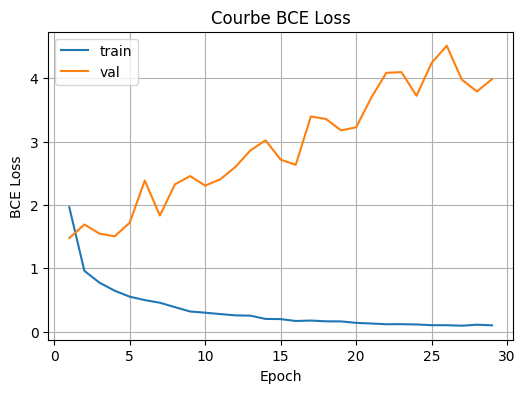

In [28]:
# Courbes d’apprentissage
plot_curves(train_losses, val_losses, ylabel="BCE Loss")


AUC test: 0.850 | F1 test: 0.718


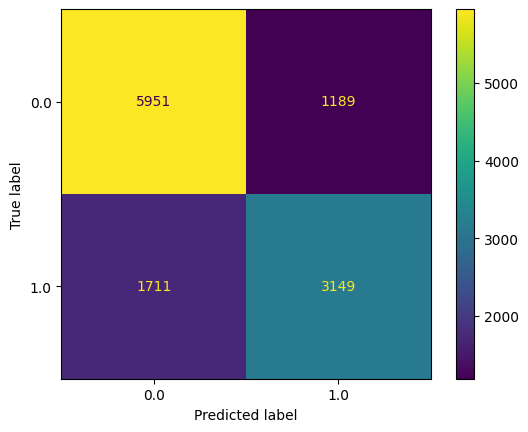

In [33]:
# ----- 11. Évaluation finale sur test -----
test_loss, test_auc, test_f1, test_probs, test_labels = eval_epoch(model_final, test_dl, nn.BCEWithLogitsLoss())
print(f"AUC test: {test_auc:.3f} | F1 test: {test_f1:.3f}")

# Confusion matrix
model_final.eval()
preds, labels = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        preds.append(torch.sigmoid(model_final(xb.to(device))).cpu())
        labels.append(yb)
preds = torch.cat(preds).numpy()
labels= torch.cat(labels).numpy()
ConfusionMatrixDisplay.from_predictions(labels, preds>0.9)
plt.show()


In [32]:
# ----- 12. Sauvegarde -----
torch.save(state, MODEL_DIR / f"{RUN_NAME}_weights.pt")

if USE_OPTUNA:
    params_to_save = {**MODEL_CFG,
        "hidden_dims": [best["h1"], best["h2"], best["h3"]],
        "lr": lr,
        "weight_decay": wd,
    }
else:
    params_to_save = {**MODEL_CFG,
        "lr": lr,
        "weight_decay": wd,
    }

with open(MODEL_DIR / f"{RUN_NAME}_params.json", "w") as fp:
    json.dump(params_to_save, fp, indent=2)
print("Artifacts saved in", MODEL_DIR)


Artifacts saved in Pytorch_models


In [ ]:
# ----- 13. Exemple d’inférence -----
sample = np.random.rand(430).reshape(1, -1)
with torch.no_grad():
    prob = torch.sigmoid(model_final(torch.tensor(sample, dtype=torch.float32).to(device))).item()
print(f"Probabilité malade: {prob:.3f}")
